## Introduction to Designing a Filter

So far we have developed filters for a position sensor. We are used to this problem by now, and may feel ill-equipped to implement a Kalman filter for a different problem. To be honest, there is still quite a bit of information missing from this presentation. Following chapters will fill in the gaps. Still, let's get a feel for it by designing and implementing a Kalman filter for a thermometer. The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. We have read the manufacturer's specifications for the sensor, and it tells us that the sensor exhibits white noise with a standard deviation of 0.13 volts.

We can simulate the temperature sensor measurement with this function:

In [25]:
def volt(voltage, std):
    return voltage + (randn() * std)

Now we need to write the Kalman filter processing loop. As with our previous problem, we need to perform a cycle of predicting and updating. The sensing step probably seems clear - call `volt()` to get the measurement, pass the result into `update()` method, but what about the predict step? We do not have a sensor to detect 'movement' in the voltage, and for any small duration we expect the voltage to remain constant. How shall we handle this?

As always, we will trust in the math. We have no known movement, so we will set that to zero. However, that means that we are predicting that the temperature will never change. If that is true, then over time we should become extremely confident in our results. Once the filter has enough measurements it will become very confident that it can predict the subsequent temperatures, and this will lead it to ignoring measurements that result due to an actual temperature change. This is called a *smug* filter, and is something you want to avoid. So we will add a bit of error to our prediction step to tell the filter not to discount changes in voltage over time. In the code below I set `process_var = .05**2`. This is the expected variance in the change of voltage over each time step. I chose this value merely to be able to show how the variance changes through the update and predict steps. For a real sensor you would set this value for the actual amount of change you expect. For example, this would be an extremely small number if it is a thermometer for ambient air temperature in a house, and a high number if this is a thermocouple in a chemical reaction chamber. We will say more about selecting the actual value in the later chapters.

Let's see what happens. 

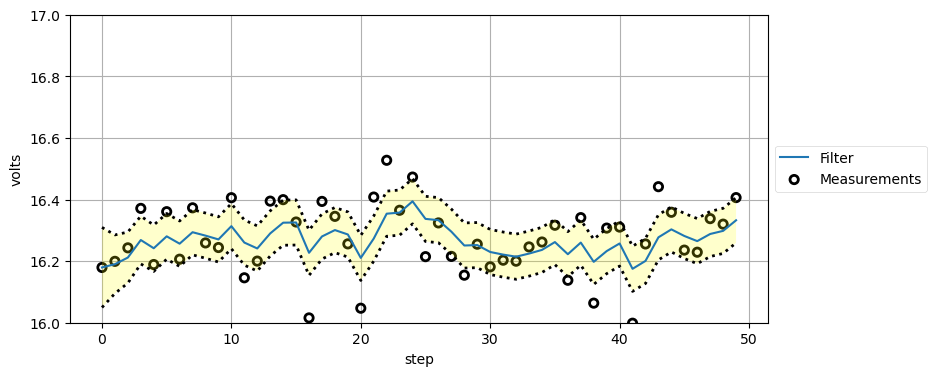

Variance converges to 0.005


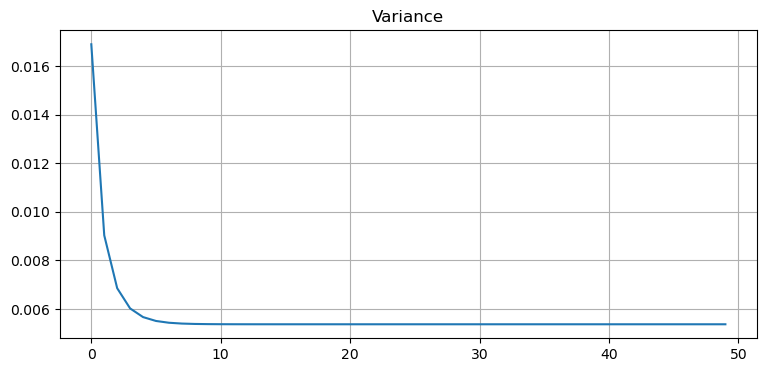

In [26]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print('Variance converges to {:.3f}'.format(ps[-1]))

The first plot shows the individual sensor measurements vs the filter output. Despite a lot of noise in the sensor we quickly discover the approximate voltage of the sensor. In the run I just completed at the time of authorship, the last voltage output from the filter is $16.213$, which is quite close to the $16.4$ used by the `volt()` function. On other runs I have gotten larger and smaller results.

Spec sheets are what they sound like - specifications. Any individual sensor will exhibit different performance based on normal manufacturing variations. Values are often maximums - the spec is a guarantee that the performance will be at least that good. If you buy an expensive piece of equipment it often comes with a sheet of paper displaying the test results of your specific item; this is usually very trustworthy. On the other hand, if this is a cheap sensor it is likely it received little to no testing prior to being sold. Manufacturers typically test a small subset of their output to verify that a sample falls within the desired performance range. If you have a critical application you will need to read the specification sheet carefully to figure out exactly what they mean by their ranges. Do they guarantee their number is a maximum, or is it, say, the $3\sigma$ error rate? Is every item tested? Is the variance normal, or some other distribution? Finally, manufacturing is not perfect. Your part might be defective and not match the performance on the sheet.

For example, I am looking at a data sheet for an airflow sensor. There is a field *Repeatability*, with the value $\pm 0.50\%$. Is this a Gaussian? Is there a bias? For example, perhaps the repeatability is nearly $0.0\%$ at low temperatures, and always nearly  $+0.50\%$ at high temperatures. Data sheets for electrical components often contain a section of "Typical Performance Characteristics". These are used to capture information that cannot be easily conveyed in a table. For example, I am looking at a chart showing output voltage vs current for a LM555 timer. There are three curves showing the performance at different temperatures. The response is ideally linear, but all three lines are curved. This clarifies that errors in voltage outputs are probably not Gaussian - in this chip's case higher temperatures lead to lower voltage output, and the voltage output is quite nonlinear if the input current is very high. 

As you might guess, modeling the performance of your sensors is one of the harder parts of creating a Kalman filter that performs well. 

## Example: Extreme Amounts of Noise

With the dog filter I didn't put a lot of noise in the signal, and I 'guessed' that the dog was at position 0. How does the filter perform in real world conditions? I will start by injecting more noise in the RFID sensor while leaving the process variance at 2 m$^2$.  I will inject an extreme amount of noise - noise that apparently swamps the actual measurement. What does your intuition say about the filter's performance if the sensor has a standard deviation of 300 meters? In other words, an actual position of 1.0 m might be reported as 287.9 m, or -589.6 m, or any other number in roughly that range. Think about it before you scroll down.

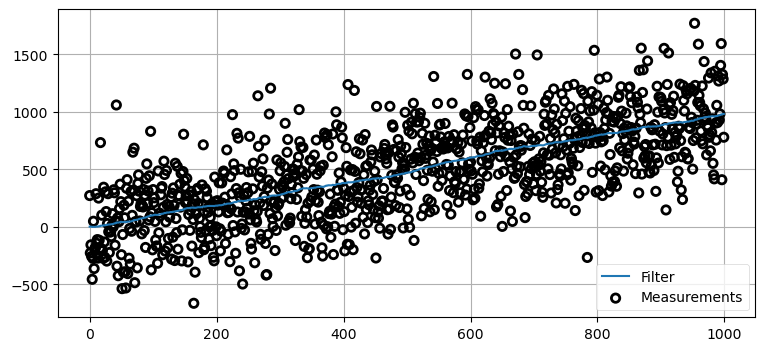

In [27]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

In this example the noise is extreme yet the filter still outputs a nearly straight line! This is an astonishing result! What do you think might be the cause of this performance? 

We get a nearly straight line because our process error is small. A small process error tells the filter that the prediction is very trustworthy, and the prediction is a straight line, so the filter outputs a nearly straight line. 

## Example: Incorrect Process Variance

That last filter looks fantastic! Why wouldn't we set the process variance very low, as it guarantees the result will be straight and smooth?

The process variance tells the filter how much the system is changing over time. If you lie to the filter by setting this number artificially low the filter will not be able to react to changes that are happening. Let's have the dog increase his velocity by a small amount at each time step and see how the filter performs with a process variance of 0.001 m$^2$.

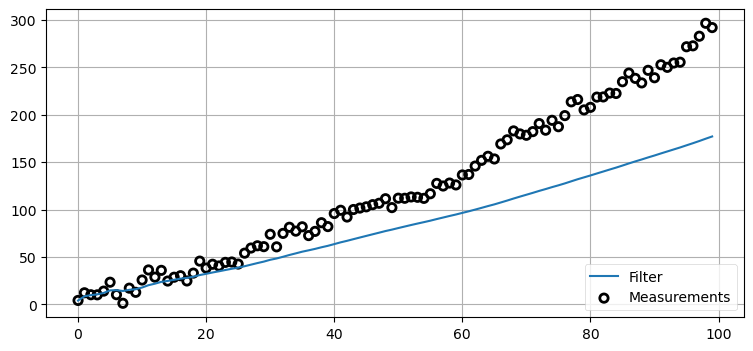

In [28]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

It is easy to see that the filter is not correctly responding to the measurements. The measurements  clearly indicate that the dog is changing speed but the filter has been told that it's predictions are nearly perfect so it almost entirely ignores them. I encourage you to adjust the amount of movement in the dog vs process variance. We will also be studying this topic much more in the later chapters. The key point is to recognize that math requires that the variances correctly describe your system. The filter does not 'notice' that it is diverging from the measurements and correct itself. It computes the Kalman gain from the variance of the prior and the measurement, and forms the estimate depending on which is more accurate.

## Example: Bad Initial Estimate


Now let's look at the results when we make a bad initial estimate of position. To avoid obscuring the results I'll reduce the sensor variance to 30, but set the initial position to 1000 meters. Can the filter recover from a 1000 meter error?

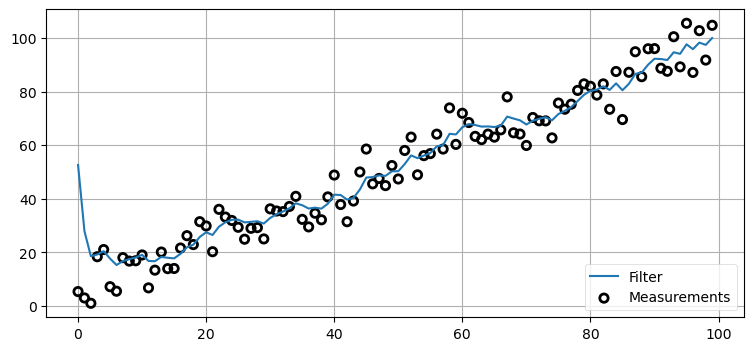

In [29]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

Again the answer is yes! Because we are relatively sure about our belief in the sensor ($\sigma^2=5^2$) after only the first step we have changed our position estimate from 1000 m to roughly 50 m. After another 5-10 measurements we have converged to the correct value. This is how we get around the chicken and egg problem of initial guesses. In practice we would likely assign the first measurement from the sensor as the initial value, but you can see it doesn't matter much if we wildly guess at the initial conditions - the Kalman filter still converges so long as the filter variances are chosen to match the actual process and measurement variances.

## Example: Large Noise and Bad Initial Estimate

What about the worst of both worlds, large noise and a bad initial estimate?

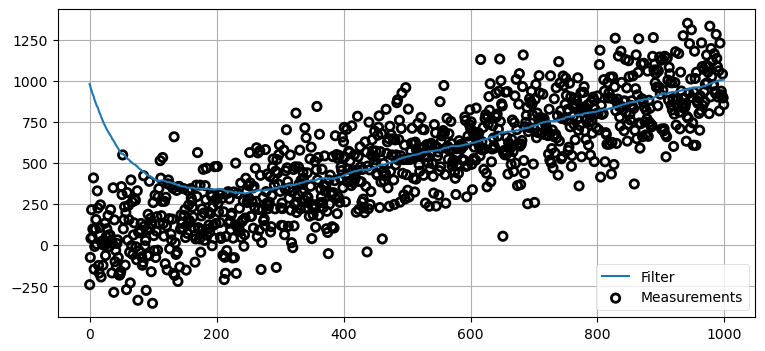

In [30]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

This time the filter struggles. Notice that the previous example only computed 100 updates, whereas this example uses 1000. By my eye it takes the filter 400 or so iterations to become reasonable accurate, but maybe over 600 before the results are good. Kalman filters are good, but we cannot expect miracles. If we have extremely noisy data and extremely bad initial conditions, this is as good as it gets.

Finally, let's implement the suggestion of using the first measurement as the initial position.

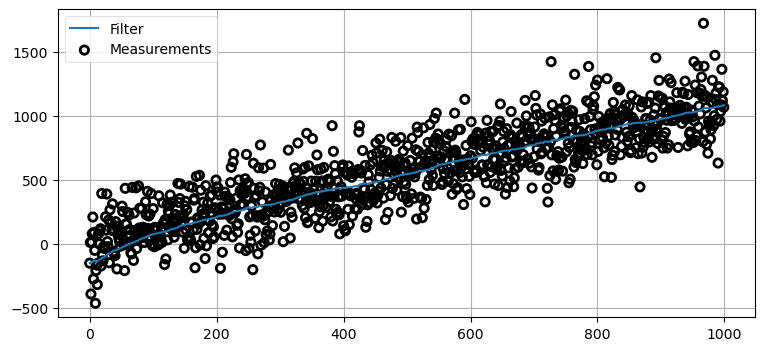

In [31]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

This simple change significantly improves the results. On some runs it takes 200 iterations or so to settle to a good solution, but other runs it converges very rapidly. This all depends on the amount of noise in the first measurement. A large amount of noise causes the initial estimate to be far from the dog's position.

200 iterations may seem like a lot, but the amount of noise we are injecting is truly huge. In the real world we use sensors like thermometers,  laser range finders, GPS satellites, computer vision, and so on. None have the enormous errors in these examples. A reasonable variance for a cheap thermometer might be 0.2 C$^{\circ 2}$, and our code is using 30,000 C$^{\circ 2}$.

## Exercise: Interactive Plots

Implement the Kalman filter using Jupyter Notebook's animation features to allow you to modify the various constants in real time using sliders. Refer to the section **Interactive Gaussians** in the **Gaussians** chapter to see how to do this. You will use the `interact()` function to call a calculation and plotting function. Each parameter passed into `interact()` automatically gets a slider created for it. I have written the boilerplate for this; you fill in the required code.

In [32]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    plt.figure();
    # your code goes here

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

### Solution

One possible solution follows. We have sliders for the start position, the amount of noise in the sensor, the amount we move in each time step, and how much movement error there is. Process noise is perhaps the least clear - it models how much the dog wanders off course at each time step, so we add that into the dog's position at each step. I set the random number generator seed so that each redraw uses the same random numbers, allowing us to compare the graphs as we move the sliders.

In [33]:
from numpy.random import seed 
from ipywidgets import interact

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = gaussian(0., 1000.) # mean and variance
    process_model = gaussian(velocity, process_noise)
    
    for z in zs:    
        pos = predict(pos, process_model)
        pos = update(pos, gaussian(z, sensor_noise))
        ps.append(pos.mean)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

## Exercise - Nonlinear Systems

Our equations for the Kalman filter are linear:

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

Do you suppose that this filter works well or poorly with nonlinear systems?

Implement a Kalman filter that uses the following equation to generate the measurement value

```python
for i in range(100):
    z = math.sin(i/3.) * 2
```
    
Adjust the variance and initial positions to see the effect. What is, for example, the result of a very bad initial guess?

In [35]:
#enter your code here.

### Solution

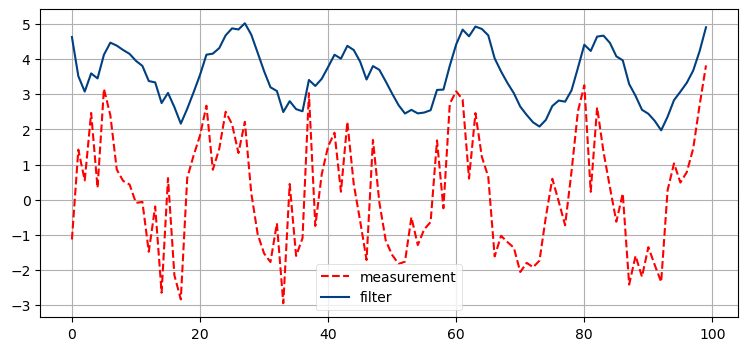

In [36]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### Discussion

This is terrible! The output is not at all like a sin wave, except in the grossest way. With linear systems we could add extreme amounts of noise to our signal and still extract a very accurate result, but here even modest noise creates a very bad result.

If we recall the **g-h Filter** chapter we can understand what is happening here. The structure of the g-h filter requires that the filter output chooses a value part way between the prediction and measurement. A varying signal like this one is always accelerating, whereas our process model assumes constant velocity, so the filter is mathematically guaranteed to always lag the input signal. 

Very shortly after practitioners began implementing Kalman filters they recognized the poor performance of them for nonlinear systems and began devising ways of dealing with it. Later chapters are devoted to this problem.

## Fixed Gain Filters

Embedded computers usually have extremely limited processors. Many do not have floating point circuitry. These simple equations can impose a heavy burden on the chip. This is less true as technology advances, but do not underestimate the value of spending one dollar less on a processor when you will be buying millions of them.

In the example above the variance of the filter converged to a fixed value. This will always happen if the variance of the measurement and process is a constant. You can take advantage of this fact by running simulations to determine what the variance converges to. Then you can hard code this value into your filter. So long as you initialize the filter to a good starting guess (I recommend using the first measurement as your initial value) the filter will perform very well. For example, the dog tracking filter can be reduced to this:

```python
def update(x, z):
    K = .13232  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + vel*dt
```

I used the Kalman gain form of the update function to emphasize that we do not need to consider the variances at all. If the variances converge to a single value so does the Kalman gain. 